In [59]:
SITE_ID    = "therealdeal.com"
API_SECRET = "Z5evAX56zI2htaKNk36665zSaJEcIGYiCZjeI7jpUzI"

In [54]:
import requests
import pandas as pd
from datetime import datetime, timedelta

SITE_ID    = "therealdeal.com"
API_SECRET = "Z5evAX56zI2htaKNk36665zSaJEcIGYiCZjeI7jpUzI"
AUTH_URL    = "https://api.parsely.com/v2/analytics/authors"

# 30-day window
now          = datetime.utcnow()
period_end   = now.isoformat()
period_start = (now - timedelta(days=30)).isoformat()

# ── 4) Fetch each section’s authors ──────────────────────────────────────────
all_rows = []

sections = ["new-york", "los-angeles", "las-vegas", "south-florida", "chicago", "national", "fort-worth", "houston"]

for section in sections:
    page = 1
    while True:
        resp = requests.get(
            AUTH_URL,
            params={
                "apikey":       SITE_ID,
                "secret":       API_SECRET,
                "section":      section,
                "period_start": period_start,
                "period_end":   period_end,
                "sort":         "views",   # or "visitors"
                "limit":        100,       # authors per page (max 100)
                "page":         page
            }
        )
        resp.raise_for_status()
        batch = resp.json().get("data", [])
        if not batch:
            break

        # tag with section and collect
        for rec in batch:
            rec["section"] = section
        all_rows.extend(batch)
        page += 1

# ── 5) Normalize and clean up ─────────────────────────────────────────────────
df = pd.json_normalize(all_rows)

df

,_hits,author,section,metrics.views
0,625158,TRD Staff,new-york,625158
1,112608,Katherine Kallergis,new-york,112608
2,109080,Brand Studio,new-york,109080
3,95979,Rich Bockmann,new-york,95979
4,78010,Francisco Alvarado,new-york,78010
...,...,...,...,...
3107,1,Robin Shear,houston,1
3108,1,Roger Drouin,houston,1
3109,1,Steven Cirvello,houston,1
3110,1,Sydnee Bursik,houston,1


In [55]:
df[df['section'] == 'houston']

,_hits,author,section,metrics.views
2723,625158,TRD Staff,houston,625158
2724,112608,Katherine Kallergis,houston,112608
2725,109080,Brand Studio,houston,109080
2726,95979,Rich Bockmann,houston,95979
2727,78010,Francisco Alvarado,houston,78010
...,...,...,...,...
3107,1,Robin Shear,houston,1
3108,1,Roger Drouin,houston,1
3109,1,Steven Cirvello,houston,1
3110,1,Sydnee Bursik,houston,1


In [56]:
df[df['section'] == 'new-york']

,_hits,author,section,metrics.views
0,625158,TRD Staff,new-york,625158
1,112608,Katherine Kallergis,new-york,112608
2,109080,Brand Studio,new-york,109080
3,95979,Rich Bockmann,new-york,95979
4,78010,Francisco Alvarado,new-york,78010
...,...,...,...,...
384,1,Robin Shear,new-york,1
385,1,Roger Drouin,new-york,1
386,1,Steven Cirvello,new-york,1
387,1,Sydnee Bursik,new-york,1


In [44]:
AUTH_URL    = "https://api.parsely.com/v2/analytics/authors"

# 30-day window
now          = datetime.utcnow()
period_end   = now.isoformat()
period_start = (now - timedelta(days=30)).isoformat()

# ── 4) Fetch each section’s authors ──────────────────────────────────────────
all_rows = []

sections = ["New York", "Los Angeles", "Las Vegas", "South Florida", "Chicago", "National", "Fort Worth", "Houston"]

for section in sections:
    page = 1
    while True:
        resp = requests.get(
            AUTH_URL,
            params={
                "apikey":       SITE_ID,
                "secret":       API_SECRET,
                "section":      section,
                "period_start": period_start,
                "period_end":   period_end,
                "sort":         "views",   # or "visitors"
                "limit":        100,       # authors per page (max 100)
                "page":         page
            }
        )
        resp.raise_for_status()
        batch = resp.json().get("data", [])
        if not batch:
            break

        # tag with section and collect
        for rec in batch:
            rec["section"] = section
        all_rows.extend(batch)
        page += 1

# ── 5) Normalize and clean up ─────────────────────────────────────────────────
df = pd.json_normalize(all_rows)

df

,_hits,author,section,metrics.views
0,624776,TRD Staff,New York,624776
1,112417,Katherine Kallergis,New York,112417
2,109068,Brand Studio,New York,109068
3,95939,Rich Bockmann,New York,95939
4,77974,Francisco Alvarado,New York,77974
...,...,...,...,...
384,1,Robin Shear,New York,1
385,1,Roger Drouin,New York,1
386,1,Steven Cirvello,New York,1
387,1,Sydnee Bursik,New York,1


In [68]:
import requests

SECS_URL = "https://api.parsely.com/v2/analytics/sections"

now = datetime.utcnow()
params = {
    "apikey":       SITE_ID,
    "secret":       API_SECRET,
    "period_start": (now - timedelta(days=30)).isoformat(),
    "period_end":   now.isoformat(),
    "limit":        1000,
    "page":         1
}

r = requests.get(SECS_URL, params=params)
r.raise_for_status()
sections_data = r.json().get("data", [])

# Extract exactly the strings you need:
available_slugs = [ rec["section"] for rec in sections_data ]
print("Available section slugs:", available_slugs)

Available section slugs: ['New York', 'South Florida', 'Los Angeles', 'National', 'Chicago', 'San Francisco', 'Dallas', 'Tri-State', 'Texas', 'Uncategorized', 'Houston', 'Austin', 'Phoenix', 'Fort Worth', 'Nashville', 'Atlanta', 'Washington D.C.', 'Seattle', 'Denver', 'Philadelphia', 'San Antonio', 'Boston', 'Las Vegas', 'Charlotte', 'Tampa', 'Orlando']


In [69]:
import requests, pandas as pd
from datetime import datetime, timedelta


POSTS_URL = "https://api.parsely.com/v2/analytics/posts"

# 30-day ISO window (no microseconds, add Z if you need UTC)
now          = datetime.utcnow().replace(microsecond=0)
period_end   = now.isoformat() + "Z"
period_start = (now - timedelta(days=30)).isoformat() + "Z"

# slugs (no brackets, no quotes)
sections = available_slugs

# ── Fetch posts per section ────────────────────────────────────────────────
all_posts = []
for section in sections:
    resp = requests.get(
        POSTS_URL,
        params={
            "apikey":       SITE_ID,
            "secret":       API_SECRET,
            "section":      section,         # plain slug
            "period_start": period_start,
            "period_end":   period_end,
            "limit":        2000,            # max you can get in one go
            "sort":         "views"
        }
    )
    resp.raise_for_status()
    data = resp.json().get("data", [])
    if not data:
        print(f"No posts returned for section={section}. Check slug or date range.")
        continue

    # tag so we know which section each post came from
    for post in data:
        post["section"] = section

    all_posts.extend(data)

# ── Roll up to per-author, per-section ──────────────────────────────────────
df = pd.json_normalize(all_posts)

# flatten out the nested views metric
df["views"] = df["metrics.views"]

# group
df_auth_sec = (
    df
    .groupby(["author","section"], dropna=False)
    .agg(pageviews=("views","sum"))
    .reset_index()
)

print(df_auth_sec.head())

            author        section  pageviews
0  Abigail Nehring    Los Angeles      27690
1  Abigail Nehring  San Francisco       7023
2     Adam Farence        Chicago          4
3     Adam Farence       National          4
4     Adam Farence  San Francisco          7


In [76]:
df_auth_sec = df_auth_sec.sort_values(by="pageviews",ascending=False)

In [84]:
df_auth_sec

,author,section,pageviews
461,TRD Staff,New York,190672
43,Brand Studio,New York,100229
403,Rich Bockmann,New York,95351
291,Katherine Kallergis,South Florida,81112
284,Kate Hinsche,South Florida,75715
...,...,...,...
222,James Kleimann,Tri-State,2
481,Ted Glanzer,Texas,1
126,Eddie Small,Tri-State,1
191,Hiten Samtani,Austin,1


In [86]:
df_filtered = df_auth_sec[df_auth_sec['author'] != 'Brand Studio']

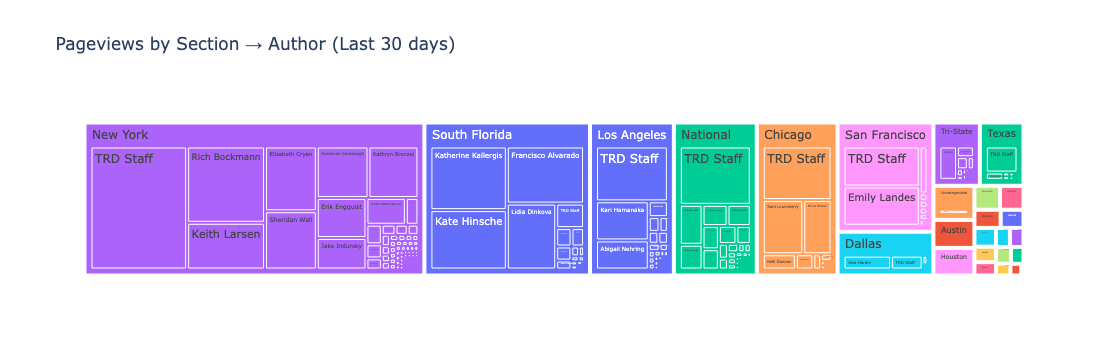

In [96]:
import plotly.express as px

fig = px.treemap(
    df_filtered,
    path=["section","author"],   # hierarchy
    values="pageviews",          # size by pageviews
    color="section",             # color by section
    hover_data=["pageviews"],    # show pageviews on hover
    title="Pageviews by Section → Author (Last 30 days)"
)
fig.write_html("index.html")
fig.show()

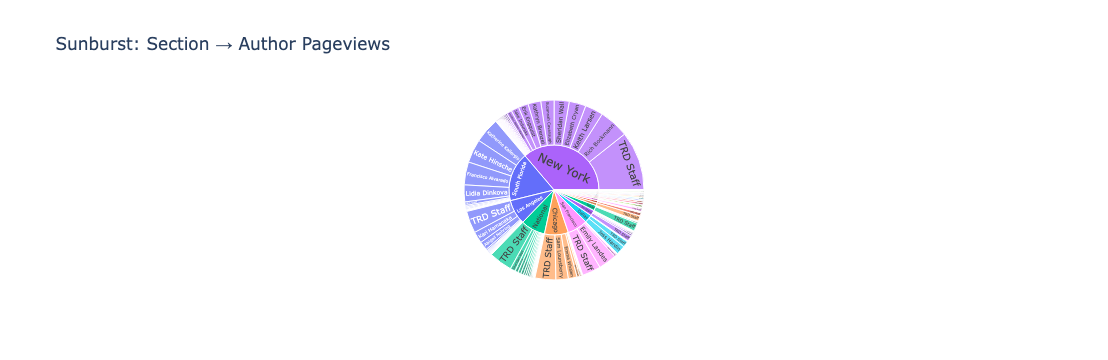

In [95]:
fig = px.sunburst(
    df_filtered,
    path=["section","author"],
    values="pageviews",
    color="section",
    hover_data=["pageviews"],
    title="Sunburst: Section → Author Pageviews"
)
fig.show()


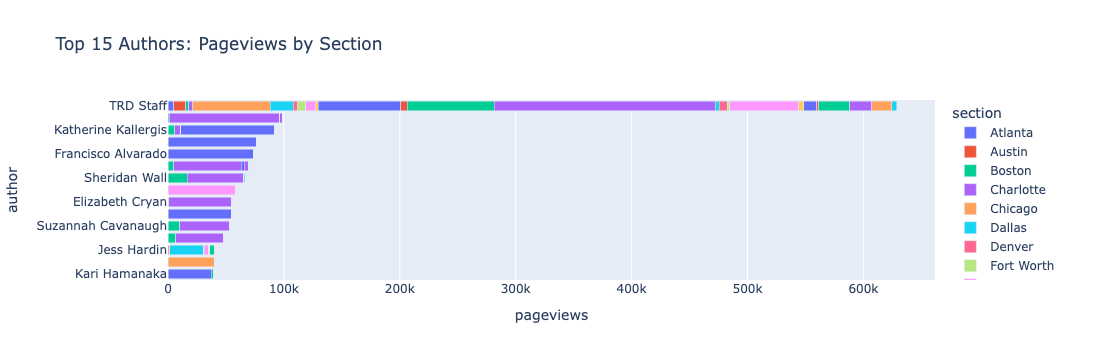

In [94]:
import pandas as pd
import plotly.express as px

# 1) compute total per author
totals = df_filtered.groupby("author")["pageviews"].sum().nlargest(15).index

# 2) filter & pivot
df_top = df_filtered[df_filtered.author.isin(totals)]
pivot = df_top.pivot_table(
    index="author",
    columns="section",
    values="pageviews",
    aggfunc="sum",
    fill_value=0
).reset_index()

# 3) melt back for plotting
melt = pivot.melt(id_vars="author", var_name="section", value_name="pageviews")

fig = px.bar(
    melt,
    x="pageviews",
    y="author",
    color="section",
    orientation="h",
    title="Top 15 Authors: Pageviews by Section",
    hover_data=["pageviews"]
)
fig.update_layout(barmode="stack", yaxis={"categoryorder":"total ascending"})
fig.show()

In [98]:
# import plotly.express as px

# heat = df_filtered.pivot_table(
#     index="author",
#     columns="section",
#     values="pageviews",
#     aggfunc="sum",
#     fill_value=0
# )

# fig = px.imshow(
#     heat,
#     labels=dict(x="Section", y="Author", color="Pageviews"),
#     title="Heatmap of Pageviews (Author × Section)"
# )
# fig.show()

In [97]:
import os

base_name = 'https://trd-digital.github.io/trd-news-interactive-maps/'

cwd = os.getcwd()

cwd = cwd.split('/')

final_name = base_name + cwd[-1]
print(final_name)

https://trd-digital.github.io/trd-news-interactive-maps/TRD_Parsely_Dataviz
